# NOAA Data Cleaning & Preprocessing

This notebook cleans and preprocesses raw NOAA ISD weather data from Kochi (2020–2024).
The goal is to convert flagged string values into numeric physical quantities,
handle missing data, and prepare the dataset for LSTM-based time-series modeling.


In [1]:
import pandas as pd
import numpy as np
from glob import glob


In [2]:
files = glob("../data/raw/noaa/kochi_*.csv")
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE').reset_index(drop=True)


In [3]:
df = df[['DATE', 'TMP', 'DEW', 'SLP']]
df.head()


,DATE,TMP,DEW,SLP
0,2020-01-01 00:00:00,"+0250,1","+0235,1","10116,1"
1,2020-01-01 03:00:00,"+0264,1","+0222,1","10140,1"
2,2020-01-01 06:00:00,"+0306,1","+0217,1","10138,1"
3,2020-01-01 09:00:00,"+0324,1","+0221,1","10112,1"
4,2020-01-01 12:00:00,"+0304,1","+0222,1","10108,1"


## Create clean extraction function


In [4]:
def extract_noaa_value(series):
    values = series.astype(str).str.split(',', expand=True)[0]
    values = values.replace(['9999', '99999'], np.nan)
    return values.astype(float)

In [5]:
df['TMP'] = extract_noaa_value(df['TMP'])
df['DEW'] = extract_noaa_value(df['DEW'])
df['SLP'] = extract_noaa_value(df['SLP'])

In [6]:
# Converting to physical units
df['temperature'] = df['TMP'] / 10.0        # °C
df['dew_point'] = df['DEW'] / 10.0           # °C
df['pressure'] = df['SLP'] / 10.0            # hPa

In [7]:
df = df[['DATE', 'temperature', 'dew_point', 'pressure']]

### Compute relative humidity

In [8]:
def compute_relative_humidity(T, Td): #better than dew point temperature signals
    return 100 * (
        np.exp((17.625 * Td) / (243.04 + Td)) /
        np.exp((17.625 * T) / (243.04 + T))
    )

df['humidity'] = compute_relative_humidity(
    df['temperature'],
    df['dew_point']
)

In [9]:
df = df[['DATE', 'temperature', 'humidity', 'pressure']]

In [10]:
df.isnull().sum()
df = df.ffill().bfill()

In [11]:
#verify clean data
df.describe()

,DATE,temperature,humidity,pressure
count,16492,16492.000000,1.649200e+04,16492.000000
mean,2022-12-12 12:33:03.034198272,42.033628,6.750185e+04,1009.742051
min,2020-01-01 00:00:00,20.600000,1.804567e-04,1000.500000
25%,2021-06-15 23:15:00,26.000000,7.103412e+01,1008.300000
50%,2022-12-05 10:30:00,27.600000,8.050956e+01,1009.700000
75%,2024-07-11 09:45:00,29.800000,9.029219e+01,1011.200000
max,2025-08-24 15:00:00,999.900000,3.627645e+07,1019.400000
std,NaN,116.674635,1.385275e+06,2.126800


In [12]:
TEMP_MIN, TEMP_MAX = 0, 50       # °C
HUM_MIN, HUM_MAX = 0, 100        # %
PRES_MIN, PRES_MAX = 900, 1100   # hPa


In [13]:
df = df[
    (df['temperature'].between(TEMP_MIN, TEMP_MAX)) &
    (df['humidity'].between(HUM_MIN, HUM_MAX)) &
    (df['pressure'].between(PRES_MIN, PRES_MAX))
]

df = df.sort_values('DATE').reset_index(drop=True)
df = df.ffill().bfill()


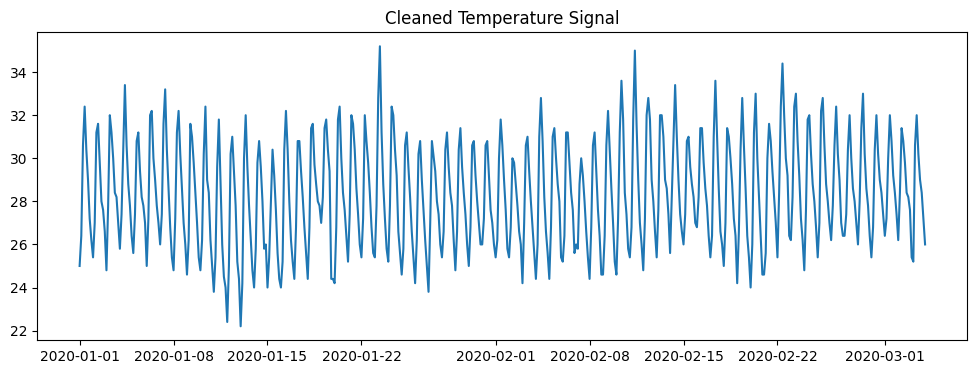

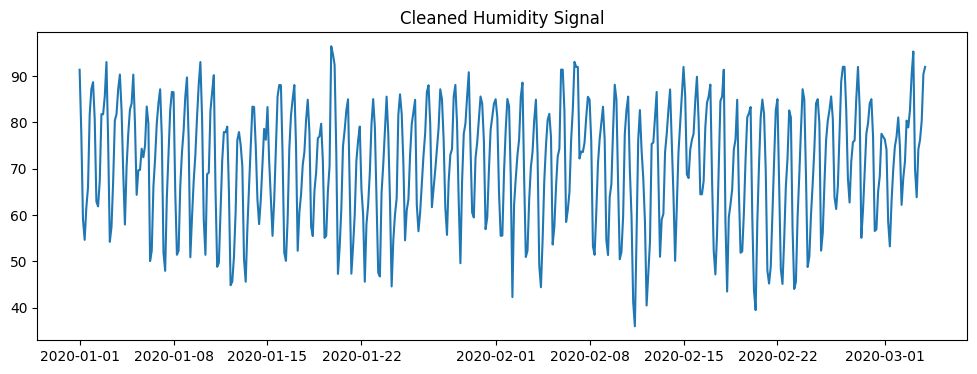

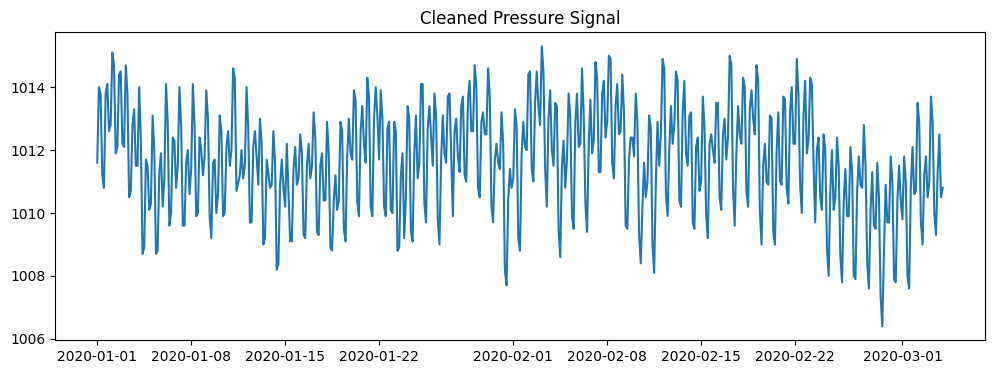

In [14]:
#plot cleaned signals
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df['DATE'][:500], df['temperature'][:500])
plt.title("Cleaned Temperature Signal")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df['DATE'][:500], df['humidity'][:500])
plt.title("Cleaned Humidity Signal")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df['DATE'][:500], df['pressure'][:500])
plt.title("Cleaned Pressure Signal")
plt.show()


## Normalize Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_values = scaler.fit_transform(
    df[['temperature', 'humidity', 'pressure']]
)

df_scaled = pd.DataFrame(
    scaled_values,
    columns=['temperature', 'humidity', 'pressure']
)

df_scaled['DATE'] = df['DATE']


In [16]:
df_scaled.to_csv(
    "../data/processed/kochi_weather_scaled.csv",
    index=False
)

In [17]:
#saving the scaler
import joblib

joblib.dump(scaler, "../models/weather_scaler.pkl")


['../models/weather_scaler.pkl']